In [1]:
from PIL import Image
import numpy as np
import nbimporter
import pickle

In [2]:
from tensorflow.keras.models import load_model
from ocr_easy import EasyReceiptOCR
from text_classification import predict_stage1_and_stage2
from text_classification import extract_text_values

In [3]:
def clean_data(data):
    cleaned_data = []
    for item in data:
        for word in item.get('words', []):
            cleaned_data.append({
                'quad': word.get('quad'),
                'text': word.get('text')
            })
    return cleaned_data

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[{'quad': {'x1': 386, 'y1': 278, 'x2': 512, 'y2': 278, 'x3': 512, 'y3': 418, 'x4': 386, 'y4': 418}, 'text': '4'}, {'quad': {'x1': 569, 'y1': 603, 'x2': 617, 'y2': 603, 'x3': 617, 'y3': 619, 'x4': 569, 'y4': 619}, 'text': '25,000'}, {'quad': {'x1': 279, 'y1': 631, 'x2': 377, 'y2': 631, 'x3': 377, 'y3': 651, 'x4': 279, 'y4': 651}, 'text': 'Mozaralla Hlot'}, {'quad': {'x1': 569, 'y1': 631, 'x2': 619, 'y2': 631, 'x3': 619, 'y3': 649, 'x4': 569, 'y4': 649}, 'text': '38,OD0'}, {'quad': {'x1': 274, 'y1': 664, 'x2': 366, 'y2': 664, 'x3': 366, 'y3': 690, 'x4': 274, 'y4': 690}, 'text': 'Chlll Pepper'}, {'quad': {'x1': 571, 'y1': 665, 'x2': 619, 'y2': 665, 'x3': 619, 'y3': 683, 'x4': 571, 'y4': 683}, 'text': '14,000'}, {'quad': {'x1': 277, 'y1': 685, 'x2': 347, 'y2': 685, 'x3': 347, 'y3': 703, 'x4': 277, 'y4': 703}, 'text': 'Croqlelte'}, {'quad': {'x1': 571, 'y1': 701, 'x2': 621, 'y2': 701, 'x3': 621, 'y3': 717, 'x4': 571, 'y4': 717}, 'text': '14,000'}, {'quad': {'x1': 275, 'y1': 737, 'x2': 377, 

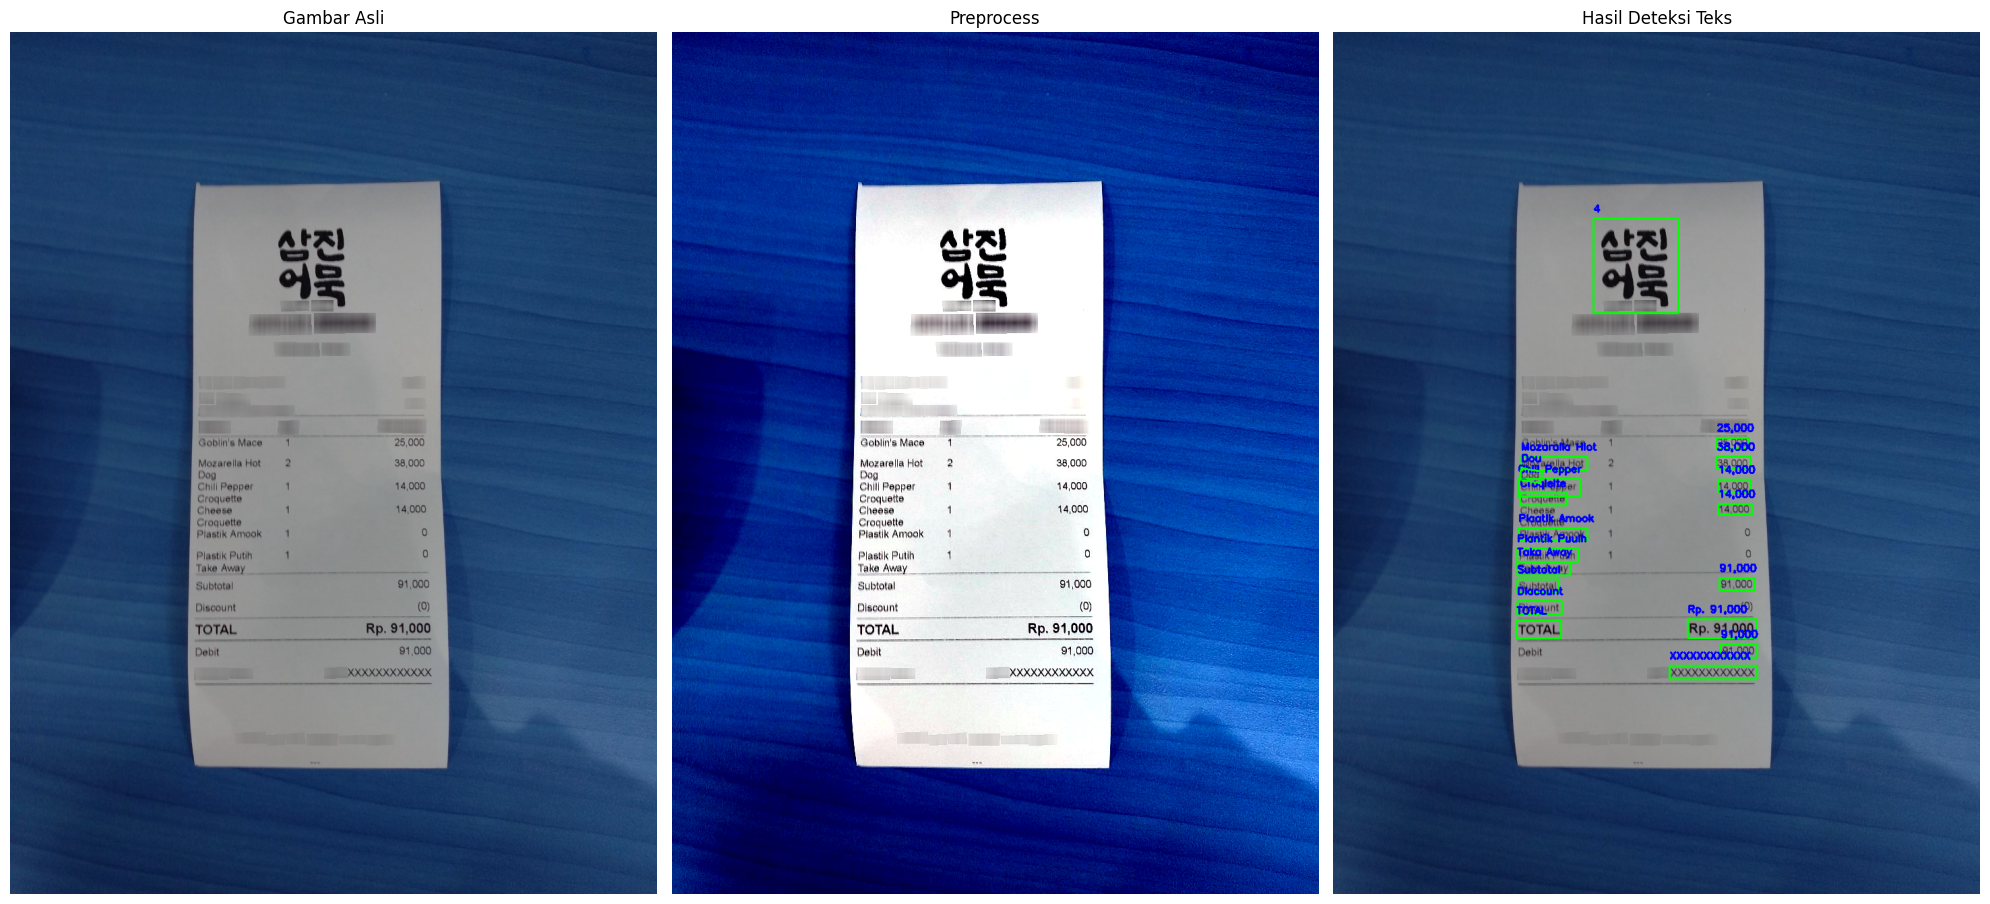


1/1 [==============================] - 1s 583ms/step
{
    "total_value": 91000.0,
    "tax_value": 0,
    "payment_method": "cash"
}


In [4]:
def main():
    # Contoh penggunaan EasyReceiptOCR
    ocr = EasyReceiptOCR(['en', 'id'])  # Menambahkan bahasa yang diperlukan, misalnya ['en', 'id']
    
    # Path gambar yang akan diproses
    image_path = "output_images_test/image_17.png"
    
    # Membaca gambar
    image = Image.open(image_path)
    image_data = np.array(image)  # Convert to NumPy array

    # Ekstraksi teks dan lokasi
    easy_results, receipt_data, visualization_image = ocr.extract_text_and_location(image_data)

    # Membersihkan hasil ekstraksi data
    cleaned_result = clean_data(receipt_data)
    print(cleaned_result)  # Verifikasi bahwa cleaned_result sudah didefinisikan

    # Menampilkan hasil deteksi
    ocr.visualize_results(image_data, visualization_image)

    # Ekstrak teks per baris
    text = ocr.extract_text_by_line(image_data)
  
    if len(image_data.shape) == 3:  # If the image has 3 dimensions (e.g., RGB)
        image_height, image_width, _ = image_data.shape  # Ignore the channels dimension
    else:
        image_height, image_width = image_data.shape  # For grayscale images, only height and width
    image_size = {'width': image_width, 'height': image_height}

    # Load the models
    model_stage1 = load_model("model_stage1.h5")
    model_stage2 = load_model("model_stage2.h5")  
    # Load tokenizers and label encoders
    with open("char_to_idx.pkl", "rb") as file:
        char_to_idx = pickle.load(file)

    with open("label_encoder_stage1.pkl", "rb") as file:
        label_encoder_stage1 = pickle.load(file)

    with open("label_encoder_stage2.pkl", "rb") as file:
        label_encoder_stage2 = pickle.load(file)

    # Prediksi menggunakan hasil yang sudah dibersihkan
    predicted_results = predict_stage1_and_stage2(
        input_data=cleaned_result,
        model_stage1=model_stage1,
        model_stage2=model_stage2,
        char_to_idx=char_to_idx,
        label_encoder_stage1=label_encoder_stage1,
        label_encoder_stage2=label_encoder_stage2,
        image_size=image_size
    )

    # Menggunakan fungsi untuk menghasilkan JSON
    result_json = extract_text_values(predicted_results)

    # Cetak hasil dalam format JSON
    import json
    print(json.dumps(result_json, indent=4))


if __name__ == "__main__":
    main()
